<a href="https://colab.research.google.com/github/alaazagha/Sales-Prediction/blob/main/Sales_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling and Evaluation of Prediction of Sales

The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.


 - Author: Alaa Zagha

## Importing Libraries

In [ ]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# Import modeling tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')


## Loading Data

In [ ]:
#loading Dataset
f_sales = "/content/drive/MyDrive/CodingDojo/01-Fundamentals/sales_predictions_2023.csv"
df = pd.read_csv(f_sales)


Initial Inspection of dataset

In [ ]:
#to see how the dataset looklike displaying first 5 rows
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


checking the size and data type of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


So the initial inspection shows:
  - The dataset has 12 cols.(features)
  - The dataset has 8523 rows (Categories)
  - 5 (41.7%) of the features are numerical data and 7(48.3%) are categorial


so after reading the features Outlet Establishment year is int, it makes sense to make it string(object) for data analysis later on

In [ ]:
#changeing year type to object
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype(object)

checking the dataset for duplicates

In [ ]:
df.duplicated().sum()


0

There are no duplicated data

lets check for missing values

In [ ]:
df.isna().sum()


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

we have 1463 numerical missing value and 2410 missng categorial

lets save each missing value in a different variable so we can clean them in the next steps

In [ ]:
#storing the categorial data in cat_cols
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [ ]:
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], dtype='object')

Finding inconsistent categories of data

In [ ]:
for col in cat_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')

Value Counts for Item_Identifier
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


Value Counts for Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


Value Counts for Outlet_Identifier
Outlet_Identifier
OUT027    935
OUT013

we found that the data in item_fat_content is incosistent there's 3 ways to describe low fat, lets agree on Low Fat to be the consistent value. Also there's two ways to describe regular lets agree on Regular

In [ ]:
#first we're replacing LF and low fat by Low Fat
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':"Low Fat",'low fat':'Low Fat', 'reg':'Regular'})
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

so Low Fat was  5089 now 5517

we noticed that Regular now is 3006 and it was 2889,so now we fixed all incosistent data

In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


## Heatmap of Correlation

In [ ]:
corr = df.corr(numeric_only = True)
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.13
Item_MRP,0.03,-0.00,1.00,0.57
Item_Outlet_Sales,0.01,-0.13,0.57,1.00


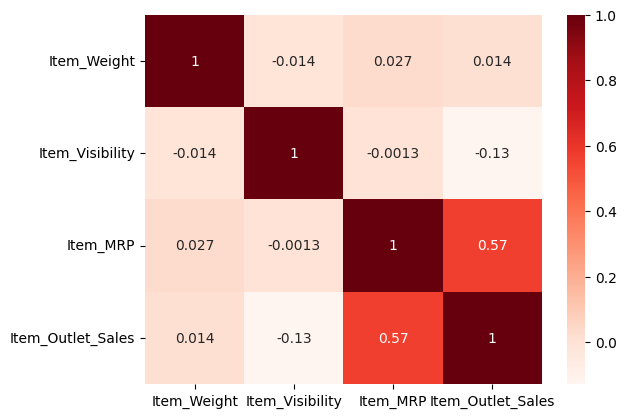

In [ ]:
sns.heatmap(corr,cmap = "Reds",annot = True);

there's a good positive correlation between Item_MRP and Outlet_sales, the higher the price of product higher sales

## Feature Inspection

## EDA function Univariate Cat

In [ ]:
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order, hue = x)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



## EDA function Univariate Num

In [ ]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")



## EDA Function Multivariate Cat Vs Target

In [ ]:
# Final version of function
def plot_categorical_vs_target(df, x, y= 'Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Stripplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



## EDA Function Multivariate Num Vs Target

In [ ]:
# Add **kwargs as keyword when defining function
# Include **kwargs in the sns.regplot() within the function

def plot_numeric_vs_target(df, x, y= 'Item_Outlet_Sales', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax



## Target is Sales

## Item_Fat_Content
- Product Fat Content
- Low Fat
- Regular

In [ ]:
feature = 'Item_Fat_Content'
df[feature].dtype

dtype('O')

<ipython-input-16-3348d7a681f3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


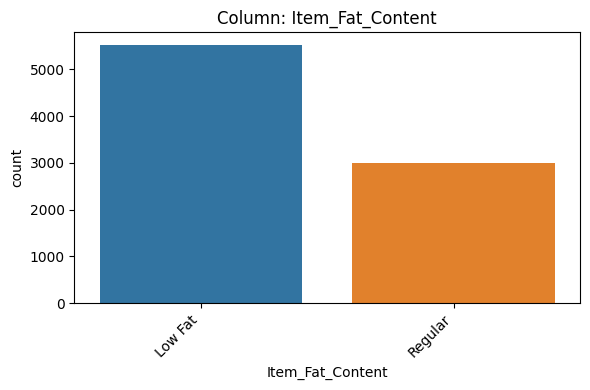

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Fat_Content'}, xlabel='Item_Fat_Content', ylabel='count'>)

In [ ]:
explore_categorical(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  -  Categorical
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 0%
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - 2 Low
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - Nope because the assumption is there's more low fat product because people will be considered not to gain weight

<ipython-input-18-cb86fc63fc84>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Fat_Content vs. Item_Outlet_Sales'}, xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>)

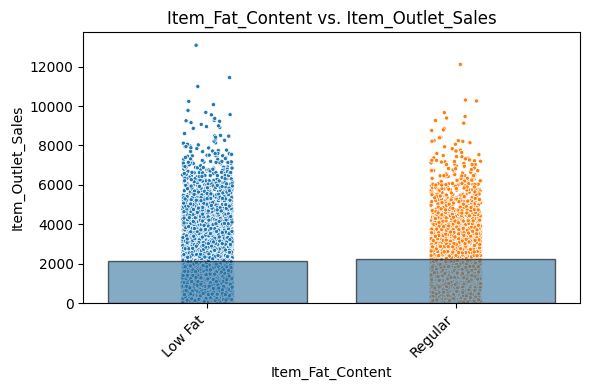

In [ ]:
plot_categorical_vs_target(df, feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like the average sales of regular products is slightly higher than low fat, but low fat has more sales values than regular so yeah it can be a predictor

- Does this feature appear to be a predictor of the target?
  - yes it can be  a predictor since theres a lot of values of sales depending on it

## Item_Type
Item_Type: the category that the product belongs to.
  - Dairy
  - soft drinks
  - Meat
  - Fruit and Vegetebales
  - Household
  - Baking Goods
  - Snack Foods
  - Frozen Foods
  - Breakfast
  - Health and Hygeine
  - Hard Drinks
  - Canned
  - Breads
  - Starchy Foods
  - Others
  - Seafood

In [ ]:
feature = 'Item_Type'
df[feature].dtype

dtype('O')

<ipython-input-66-3348d7a681f3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


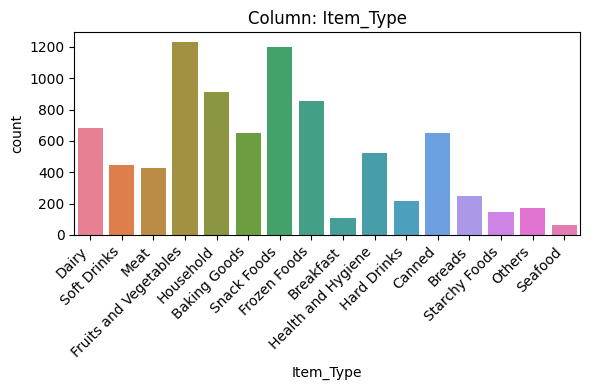

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Type'}, xlabel='Item_Type', ylabel='count'>)

In [ ]:
explore_categorical(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 0%
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - 16 High
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - High Cardinality, however I think its important to know the product that sells the most to predict the sales

<ipython-input-63-83bc0f1f214d>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Type vs. Item_Outlet_Sales'}, xlabel='Item_Type', ylabel='Item_Outlet_Sales'>)

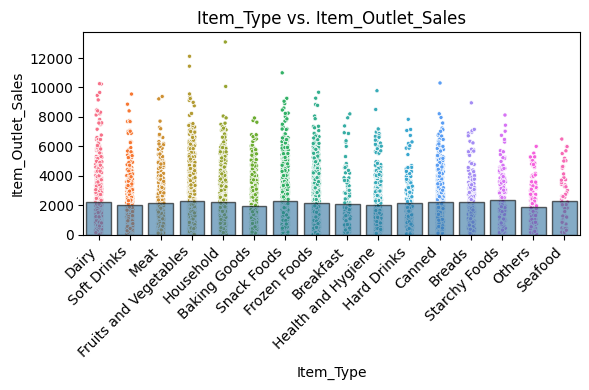

In [ ]:
plot_categorical_vs_target(df, feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like the average sales of Fruits and Vegetables is slightly higher than other Snack Foods

- Does this feature appear to be a predictor of the target?
  - yes it can be  a predictor since theres a lot of values of sales depending on it

## Item_MRP
Maximum Retail Price (list price) of the product

In [ ]:
feature = 'Item_MRP'
df[feature].dtype

dtype('float64')

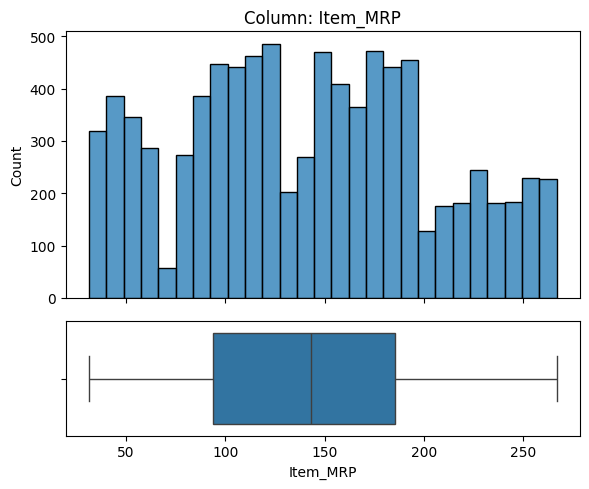

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  -  Numeric
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 0%
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - Not Applicable
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - nope beceause for sure the product price will help to predict sales

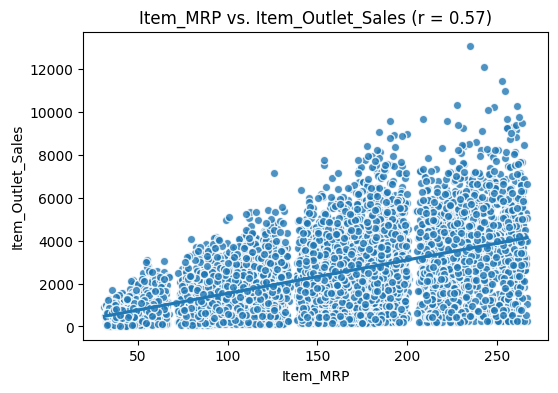

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_MRP vs. Item_Outlet_Sales (r = 0.57)'}, xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>)

In [ ]:
plot_numeric_vs_target(df, feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like there's a good positive correlation between MRP and sales which means yes its a predictor
- Does this feature appear to be a predictor of the target?
  - yes it can be  a predictor since theres a good positive correlation between them

## Item_Visibility
Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product

In [ ]:
feature = 'Item_Visibility'
df[feature].dtype

dtype('float64')

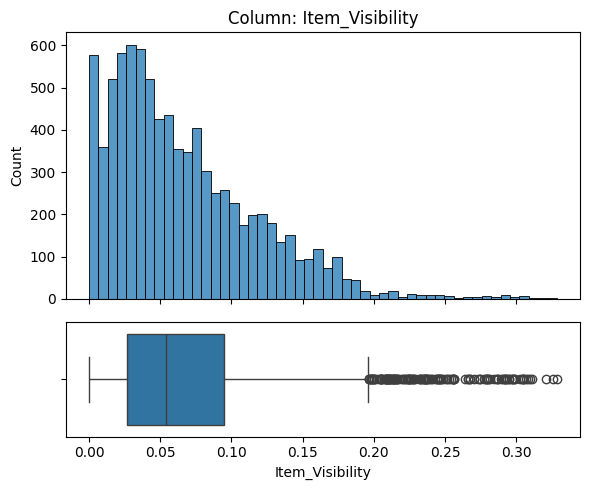

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  -  Numeric
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 0%
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - Not Applicable
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - Nope,There might be a connection between visibility and sales

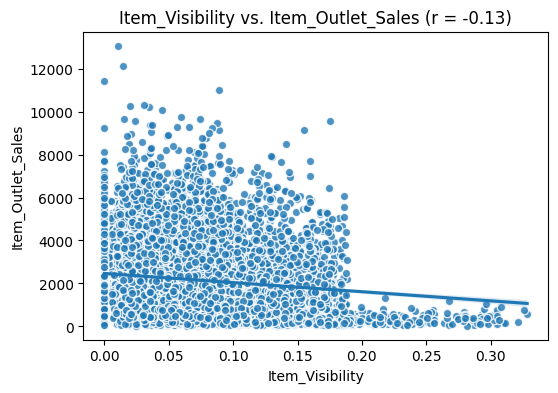

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Visibility vs. Item_Outlet_Sales (r = -0.13)'}, xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>)

In [ ]:
plot_numeric_vs_target(df,feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like there's a weak negative correlation between sales and visibility so its not a predictor
- Does this feature appear to be a predictor of the target?
  - its a very low predictor

## Item_Weight
Item_Wight: Weight of product

In [ ]:
feature = 'Item_Weight'
df[feature].dtype

dtype('float64')

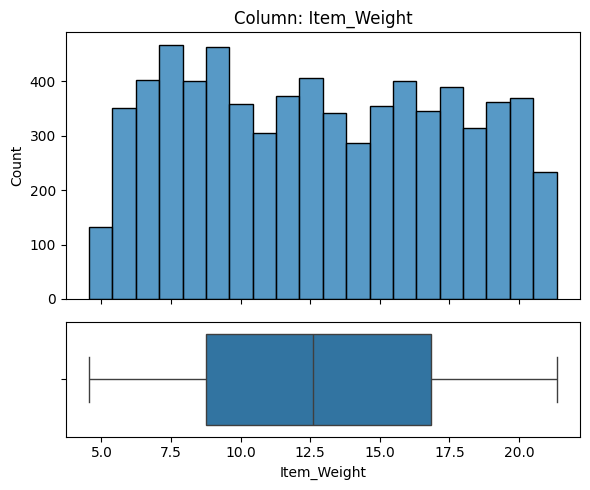

- NaN's Found: 1463 (17.17%)


In [ ]:
explore_numeric(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  -  Numeric
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 17.17%, will be imputed by mean since it describe more than 50% of the data
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - Not Applicable
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - Nope, there might be a slight connection

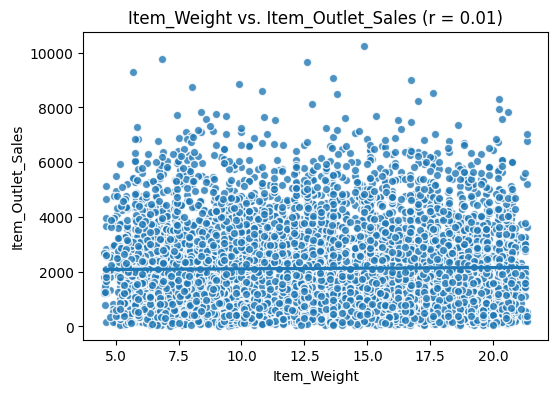

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Weight vs. Item_Outlet_Sales (r = 0.01)'}, xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>)

In [ ]:
plot_numeric_vs_target(df,feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like there's a weak positive correlation between sales and weight so its not a predictor
- Does this feature appear to be a predictor of the target?
  - its a very weak predictor

## Outlet_Type
Item_Type: Whether the outlet is a grocery store or some sort of supermarket
  - Grocery Store
  - Supermarket type 1
  - Supermarket type 2
  - Supermarket type 3


In [ ]:
feature = 'Outlet_Type'
df[feature].dtype

dtype('O')

<ipython-input-39-3348d7a681f3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


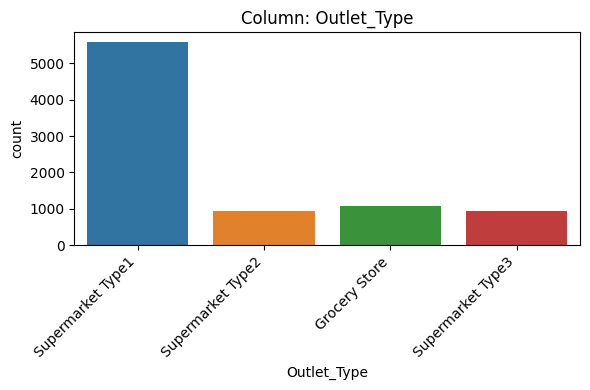

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Type'}, xlabel='Outlet_Type', ylabel='count'>)

In [ ]:
explore_categorical(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 0%
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - 4 Low
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - I think its important to know the outlet type that sells the most to predict the sales

<ipython-input-41-cb86fc63fc84>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Type vs. Item_Outlet_Sales'}, xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>)

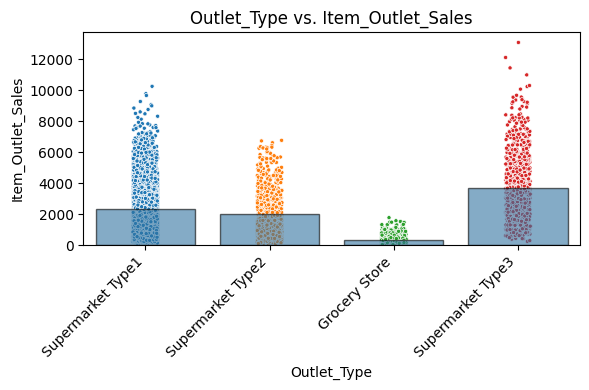

In [ ]:
plot_categorical_vs_target(df, feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like the average sales of type 3 supermarket  is higher than other stores

- Does this feature appear to be a predictor of the target?
  - yes it can be  a predictor since theres a lot of values of sales depending on it

## Item_Identifier
Item_Identifier: Product ID


In [ ]:
feature = 'Item_Identifier'
df[feature].dtype

dtype('O')

<ipython-input-39-3348d7a681f3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


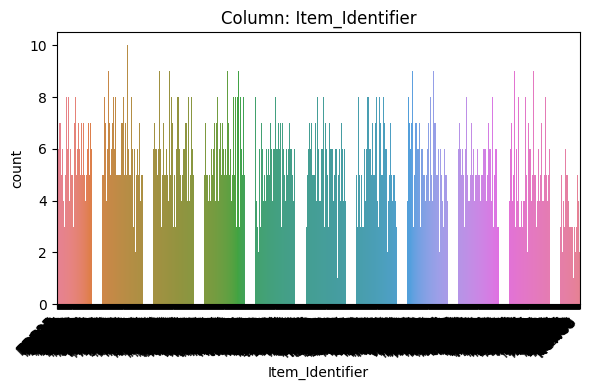

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'FDW13' occurs 10 times (0.12%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Identifier'}, xlabel='Item_Identifier', ylabel='count'>)

In [ ]:
explore_categorical(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 0%
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - 1559 Extremly High
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - yes it has a very high cardinality

## Outlet_Size
  Outlet_Size: The size of the store in terms of ground area covered.
  - Small
  - Medium
  - High

In [ ]:
feature = 'Outlet_Size'
df[feature].dtype

dtype('O')

<ipython-input-16-3348d7a681f3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


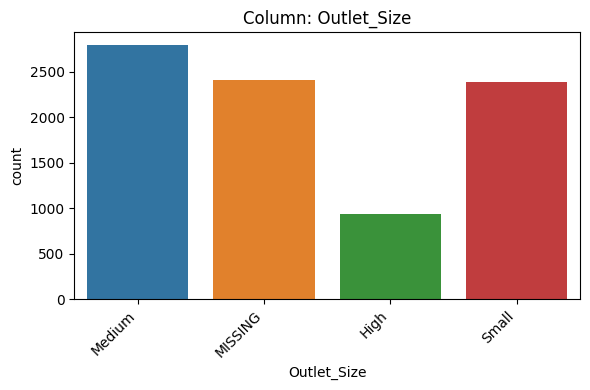

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Size'}, xlabel='Outlet_Size', ylabel='count'>)

In [ ]:
explore_categorical(df, feature)

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - none 28.28%, will be imputed by most frequent in the model
- Is the feature constant or quasi-constant?
  - not constant nor quasi constant
- What is the cardinality? Is it high (>10)?
  - 4 Low
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - nope, there might be a conncetion

<ipython-input-18-cb86fc63fc84>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Size vs. Item_Outlet_Sales'}, xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>)

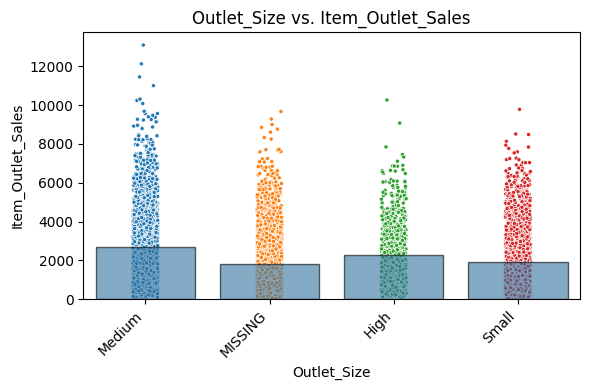

In [ ]:
plot_categorical_vs_target(df, feature)

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - like the medium size outlets have the highest average sales

- Does this feature appear to be a predictor of the target?
  - yes it can be  a predictor since theres a lot of values of sales depending on it

## Train/Test Split the data

In [ ]:
y = df['Item_Outlet_Sales']
X = df.drop(columns = ['Item_Outlet_Sales','Item_Identifier'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Preprocessing

In [ ]:
num_features = X_train.select_dtypes('number').columns
ord_features = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type']
cat_features = X_train.select_dtypes('object').drop(columns = ord_features).columns

In [ ]:
impute_mean = SimpleImputer(strategy = 'mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_mean,scaler)
num_tuple = ('Numerical',num_pipe,num_features)
ord_fat = ['Low Fat','Regular']
ord_size = ['Small','Medium','High']
ord_type = ['Tier 1','Tier 2','Tier 3']
ord_orders = [ord_fat,ord_size,ord_type]
ord_encoder = OrdinalEncoder(categories = ord_orders)
ord_scaler = StandardScaler()
ord_impute = SimpleImputer(strategy = 'most_frequent')
ord_pipe = make_pipeline(ord_impute,ord_encoder,ord_scaler)
ord_tuple = ('Ordinal',ord_pipe,ord_features)
cat_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
cat_impute = SimpleImputer(strategy = 'most_frequent')
cat_pipe = make_pipeline(cat_impute,cat_encoder)
cat_tuple = ('Categorical',cat_pipe,cat_features)
col_trans = ColumnTransformer([num_tuple,ord_tuple,cat_tuple], verbose_feature_names_out= False)


## Linear Regression Model

In [ ]:
lin_reg_model = LinearRegression()
lin_reg_pipe = make_pipeline(col_trans,lin_reg_model)
lin_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('Ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEn...
                                                   'Outlet_Location_Type']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [ ]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [ ]:
evaluate_regression(lin_reg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.112
- MSE = 1,297,556.934
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.096
- MSE = 1,194,301.678
- RMSE = 1,092.841
- R^2 = 0.567


In [ ]:
y.describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

well since there's a big variance between the values in the target and thats because of the difference between the stores types, like the std is 1700 USD, and the mean is 2181 USD the mae for the model is 804 USD which means there's a 36.8% percentage of error in the predicted values

## RandomForrest Model

In [ ]:
rf_model = RandomForestRegressor()
rf_pipe = make_pipeline(col_trans,rf_model)
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('Ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEn...
                                                 ('Categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.842
- MSE = 182,398.694
- RMSE = 427.082
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 771.902
- MSE = 1,236,243.851
- RMSE = 1,111.865
- R^2 = 0.552


In [ ]:
y.describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

There's definetly overfitting because the values of metrics of the testing data are 3 times bigger than the metrics of the training data, however the model is slightly better than the linear regression model because the mae is 772 USD which means there's a 35.4% of errors in prediction  

The model is too overfit because the R2 on the training data is higher

## GridSearch CV

In [ ]:
params = {'randomforestregressor__max_depth': [10,15,20,30],
          'randomforestregressor__n_estimators':[10,100,150,200],
          }

In [ ]:
grid_search = GridSearchCV(rf_pipe, params, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                                        ('Ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('or...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Type'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [10, 15, 20, 30],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200]},
             verbose=1)

In [ ]:
best_rf = grid_search.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 644.346
- MSE = 827,905.386
- RMSE = 909.893
- R^2 = 0.720

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 741.006
- MSE = 1,132,285.146
- RMSE = 1,064.089
- R^2 = 0.590


In [ ]:
y.describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

The model is doing better than the default hyperparameters, less overfit than the default and the linear regression model, also has the lowest error rate which is 34%

## Evaluation

- Overall, which model do you recommend?
    - The tuned RandomForest model will be recommended since it has the lowest MAE,MSE and RMSE which means the least error between the other models that were mentioned earlier

- Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
  - the model can predict the sales, however the model can predict 59% of the total sales picture which means the model will have a 41% margin or wrong predictions

- Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
  - The MAE and RMSE means that if the prediction value is compared with the real value this would be the difference between them so there will be a 1064 USD difference betweeen the prediction value of sales and the real value of sales if using the RMSE to evaluate if choosing the MAE it will be 742 USD

- Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?
  - still the model is overfitted since its doing better on the training data